In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import TensorDataset, Dataset, IterableDataset
import models as clModel,dutils
import cladec
import numpy as np,os
import torch.cuda.amp as tca
from matplotlib import pyplot as plt
import pdb
from tqdm import tqdm

In [12]:
class LargeActDataset(IterableDataset):
    def __init__(self, orig_loader, act_model, device):
        super(LargeActDataset, self).__init__()
        self.orig_loader = orig_loader
        self.act_model = act_model
        self.device = device


    def __iter__(self) :
        for (img, label) in self.orig_loader:
            with torch.no_grad():
                with tca.autocast():
                    act = self.act_model(img.to(self.device)).detach().cpu()
            yield (img.detach().cpu(), label, act)



In [13]:
def getActs(ds,actModel,cfg):
    dsact = LargeActDataset(ds, actModel, cfg["device"])
    return torch.utils.data.DataLoader(dsact, batch_size=1)


In [5]:
dummy=False
#dummy = True
#cfg={ 'ds': ('Fash', 10),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
#      'batchSize': 128, 'opt': ('S', 1 if dummy else 64, 0.1, 0.0001), #optimizer settings
#      'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
#      'alpha': 0.001, #tradeoff parameter reconstruction vs. classification loss
#      'ntrain': 500 if dummy else 60000}
cfg={ 'ds': ('TinyImgNet', 200),  #Dataset either  ('Ci100', 100) or ('Ci10', 10)
    'batchSize': 128, 'opt': ('S', 1 if dummy else 60, 0.001, 0.0002), #optimizer settings
    'layInd':-1, #Layer to explain (from last layer back, ie. -1 is last (linear), -2 is last conv, -3 second last conv)
    'alpha': 0.001, #tradeoff parameter reconstruction vs. classification loss
    'ntrain': 500 if dummy else 100000}
print("Executing config",cfg)
cfg["num_classes"]=cfg["ds"][1]
#Get Data
print("Get dataset")
#train_loader, val_loader,_, trainset, valset=dutils.getFullDS(cfg)


Executing config {'ds': ('TinyImgNet', 200), 'batchSize': 128, 'opt': ('S', 60, 0.001, 0.0002), 'layInd': -1, 'alpha': 0.001, 'ntrain': 100000}
Get dataset


In [10]:
%%time  
# Train and save non-reflective Model
classifier, lcfg = clModel.getclassifier(cfg,  train_loader, val_loader, norm=None)
print("Classifier Accuracy",lcfg)

trained_model_path = "trained_models/TinyImgNet_final"
import os
os.makedirs(trained_model_path, exist_ok=True)
torch.save(classifier, os.path.join(trained_model_path, "classifier_new.pt"))

  0%|          | 0/782 [00:00<?, ?it/s]

Train Classifier to explain


  0%|          | 0/782 [00:00<?, ?it/s]98s/it]

0 [4.68006 0.0542  0.05053]


  0%|          | 0/782 [00:00<?, ?it/s]54s/it]

4 [3.85882 0.2015  0.17486]


  0%|          | 0/782 [00:00<?, ?it/s]77s/it]

8 [3.4955  0.245   0.23522]


  0%|          | 0/782 [00:00<?, ?it/s].98s/it]

12 [3.3702  0.2935  0.28193]


  0%|          | 0/782 [00:00<?, ?it/s].36s/it]

20 [3.13028 0.3542  0.32352]


  0%|          | 0/782 [00:00<?, ?it/s].90s/it]

40 [2.61135 0.4391  0.43898]


100%|██████████| 60/60 [24:47<00:00, 24.80s/it]


Classifier Accuracy {'testAcc': 0.4626, 'trainAcc': 0.47157}
CPU times: user 13min 53s, sys: 1min 42s, total: 15min 35s
Wall time: 25min 10s


In [6]:
trained_model_path = "trained_models/TinyImgNet_final"
import os
classifier = torch.load(os.path.join(trained_model_path, "classifier_new.pt"))

In [7]:
cfg["device"] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
classifier.to(cfg["device"])
classifier.eval()
model_path = trained_model_path

In [10]:
cfg["opt"] = ('S', 1 if dummy else 60, 0.001, 0.0002)

In [7]:
from dutils import NumpyFolder
def getActs(cfg, model_path, train=True):
    activations_path = os.path.join(model_path, "activations_{}".format(str(-1*cfg["layInd"])), "train" if train else "val")
    dset = NumpyFolder(root = activations_path)
    return torch.utils.data.DataLoader(dset, batch_size=cfg["batchSize"], shuffle=train,num_workers=4)


In [14]:
train_loader, val_loader,_, trainset, valset=dutils.getFullDS(cfg, reconstr=True)
model_path = trained_model_path

In [11]:
for i in range(5, 6):
    refae_path = os.path.join(model_path, "refAE_{}.pt".format(str(i)))
    cladec_path = os.path.join(model_path, "cladecNet_{}.pt".format(str(i)))
    cfg["layInd"] = -1*i
    #get Activations
    actModel = cladec.getActModel(cfg, classifier)
    actModel.eval()
    #trds=getActs(cfg, model_path, train=True)
    trds=getActs(cfg, train_loader, actModel)
    if i>5:
        #get RefAE
        refAE,rcfg =cladec.getRefAE(cfg,trds, train_loader) #Does not use activations themselves, only needs shape
        print(rcfg)
        torch.save(refAE, refae_path)
    # Train ClaDec
    cladecNet,ccfg=cladec.getClaDec(cfg,classifier,None,trds)
    print("ClaDec Final loss", ccfg)
    torch.save(cladecNet, cladec_path)


Train CLaDec


  2%|▏         | 1/60 [00:23<23:25, 23.81s/it]

0 [0.02606 0.02165 4.43967]


  5%|▌         | 3/60 [01:11<22:39, 23.84s/it]

2 [0.02222 0.01787 4.36731]


  8%|▊         | 5/60 [01:59<21:48, 23.79s/it]

4 [0.02067 0.01732 3.36654]


 12%|█▏        | 7/60 [02:46<21:03, 23.83s/it]

6 [0.02036 0.01682 3.54999]


 15%|█▌        | 9/60 [03:34<20:11, 23.76s/it]

8 [0.01936 0.01607 3.31534]


 18%|█▊        | 11/60 [04:21<19:24, 23.77s/it]

10 [0.0192  0.01555 3.66598]


 35%|███▌      | 21/60 [15:04<43:29, 66.91s/it]   

20 [0.01816 0.01493 3.24671]


 52%|█████▏    | 31/60 [24:00<26:06, 54.00s/it]

30 [0.01731 0.01425 3.07142]


 68%|██████▊   | 41/60 [32:56<17:02, 53.80s/it]

40 [0.01763 0.0144  3.23853]


 85%|████████▌ | 51/60 [41:53<08:04, 53.89s/it]

50 [0.01762 0.01432 3.31319]


100%|██████████| 60/60 [49:56<00:00, 49.95s/it]

ClaDec Final loss {'ClaLo': 0.01729867437395403}


In [ ]:
ccfg

In [ ]:
torch.save(val_loader, os.path.join(model_path, "original.pt"))

In [12]:
(batch, label) = next(iter(val_loader))

In [20]:
from dutils import getnorm
import torchvision.transforms as transforms

class LargeReconstrDataset(IterableDataset):
    def __init__(self, orig_loader, model, device, train):
        super(LargeReconstrDataset, self).__init__()
        self.orig_loader = orig_loader
        self.model = model
        self.device = device
        norm = getnorm("TinyImgNet")
        tr_list = [transforms.Normalize(mean = norm[0], std=norm[1])]
        if train:
            tr_list.append(transforms.RandomResizedCrop(64))
            tr_list.append(transforms.RandomHorizontalFlip())
            
        self.transform = transforms.Compose(tr_list)

    def __iter__(self) :
        for (img, label) in self.orig_loader:
            with torch.no_grad():
                with tca.autocast():
                    reconstr = self.model(img.to(self.device)).detach().cpu()
                reconstr = self.transform(reconstr)
            yield (reconstr, label)

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

def getReconstr(cfg, model_path, cladec=True, train=True):
    rec_path = os.path.join(model_path, "rec_cladec" if cladec else "rec_refae", "reconstructions_{}".format(str(-1*cfg["layInd"])),"train" if train else "val")
    if train:
        transform = transforms.Compose([transforms.ToTensor(), transforms.RandomResizedCrop(64), transforms.RandomHorizontalFlip()])
    else:
        transform = transforms.ToTensor()
    ds_reconstr = ImageFolder(rec_path, transform = transform)
    return torch.utils.data.DataLoader(ds_reconstr, batch_size=cfg["batchSize"], shuffle=train, num_workers = 4)


In [16]:
def getReconstrDS(acts_ds,refAE,cladecNet):
    cladec_loss, refae_loss = 0, 0
    for i, data in enumerate(tqdm(acts_ds, position=0, leave=True)):
        #if i > 2: break
        with tca.autocast():
            with torch.no_grad():
                dsx, dsact = data[0].cuda(), data[2].cuda()
                if len(dsx.size()) == 5:
                    dsx = dsx.squeeze(0)
                    dsact = dsact.squeeze(0)
                outCla = cladecNet(dsact).detach().cpu().float()
                outAE = refAE(dsx).detach().cpu().float()
                dsx = dsx.detach().squeeze().cpu().float()
                cladec_loss += (outCla - dsx).pow(2).mean()
                refae_loss += (outAE - dsx).pow(2).mean()
    
    
    refae_loss = refae_loss/i
    cladec_loss = cladec_loss/i
    return cladec_loss, refae_loss
        #X=torch.cat(X,dim=0)
        #y=torch.cat(y, dim=0)
        #dsact=TensorDataset(X,y,conacts)
        #return torch.utils.data.DataLoader(dsact, batch_size=cfg["batchSize"], shuffle=True, num_workers=4)


In [55]:
dat = next(iter(cladec_train))

In [65]:
dat[1]

tensor([[172, 182,  34,  62,  57,   8, 174,  95, 176,  35, 185, 163, 103, 126,
         183, 141,  51,  13,  10, 118,  85, 172,  27, 158, 142, 123, 174, 165,
          36,  79, 109, 132, 181, 137, 128, 164,  65, 156, 171, 187,  98,  70,
           6,  61,  50,  50,   4,  90, 117, 153,  60,  85, 107,  49,  57,  26,
         166,  98,  76,  33,  30,  75,  62, 152,  90,  19,  21,   1, 195, 118,
         161,  25,  71,  15,  87, 149, 102, 168, 173, 115, 197,   3, 199, 140,
          11,  97, 140, 123, 127,  72,  39,  63,  56, 172, 141, 117, 123,  86,
          42,   2, 196,  16,  20,  89, 175,  27, 175, 128,  62, 140,  52, 194,
         101, 121, 158, 118,  80,  73,  88,  80,  58, 168, 114,  12,  21,  42,
          41, 184]])

In [60]:
loss = torch.nn.CrossEntropyLoss()


In [14]:
from models import getAcc
from tqdm import tqdm
for i in tqdm(range(1,6)):
    refAE = torch.load("trained_models/TinyImgNet/temp_refAE_"+  str(i) + ".pt")
    cladecNet = torch.load("trained_models/TinyImgNet/temp_cladecNet_"+  str(i) + ".pt")
    clf_cladec = torch.load("trained_models/TinyImgNet/clf_cladec_" + str(i) + ".pt")
    clf_ae = torch.load("trained_models/TinyImgNet/clf_ae_" + str(i) + ".pt")
    cfg["layInd"] = -1*i
    
    actModel = cladec.getActModel(cfg, classifier)
    refAE.eval()
    cladecNet.eval()
    actModel.eval()
    
    train_acts = getActs(train_loader, actModel, cfg)
    val_acts = getActs(val_loader, actModel, cfg)
    
    cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet)
    cladec_val= getReconstr(val_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=False)
    refae_val = getReconstr(val_loader, refAE,cfg)
    cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet)
    
    ae_train_loss_list.append(refae_train_loss)
    ae_val_loss_list.append(refae_val_loss)
    cladec_train_loss_list.append(cladec_train_loss)
    cladec_val_loss_list.append(cladec_val_loss)

    lcfg_cladec = {}
    lcfg_ae = {}
    lcfg_ae["testAcc"] = getAcc(clf_ae, refae_val,  niter=1e10,norm=None)
    lcfg_cladec["testAcc"] = getAcc(clf_cladec, cladec_val,  niter=1e10,norm=None)

    cladec_val_acc.append(lcfg_cladec["testAcc"])
    refae_val_acc.append(lcfg_ae["testAcc"])
torch.save(reconstr_ae,"trained_models/TinyImgNet/reconstr_ae.pt")
torch.save(reconstr_cladec,"trained_models/TinyImgNet/reconstr_cladec.pt")
torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, "cladec_metrics.pt")
torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, "ae_metrics.pt")




782it [00:32, 24.43it/s]
782it [00:32, 24.26it/s]
782it [00:30, 25.64it/s]
782it [00:30, 25.82it/s]
782it [00:30, 25.64it/s]
782it [00:30, 26.05it/s]
782it [00:30, 25.82it/s]
782it [00:30, 25.65it/s]
 80%|████████  | 4/5 [04:24<01:05, 65.64s/it]


In [ ]:
ae_train_loss_list = []
ae_val_loss_list = []
cladec_train_loss_list = []
cladec_val_loss_list = []
cladec_val_acc = []
refae_val_acc = []


for i in tqdm(range(2,6)):
    refAE = torch.load(os.path.join(model_path, "refAE_"+  str(i) + ".pt"))
    cladecNet = torch.load(os.path.join(model_path, "cladecNet_"+  str(i) + ".pt"))
    cfg["layInd"] = -1*i
    
    actModel = cladec.getActModel(cfg, classifier)
    refAE.eval()
    cladecNet.eval()
    actModel.eval()
    
    train_acts = getActs(train_loader, actModel, cfg)
    val_acts = getActs(val_loader, actModel, cfg)
    
    cladec_train = getReconstr(cfg, model_path, cladec=True, train=True)
    refae_train = getReconstr(cfg, model_path, cladec=False, train=True)
    cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet)
    cladec_val= getReconstr(cfg, model_path, cladec=True, train=False)
    refae_val = getReconstr(cfg, model_path, cladec=False, train=False)
    cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet)
    
    ae_train_loss_list.append(refae_train_loss)
    ae_val_loss_list.append(refae_val_loss)
    cladec_train_loss_list.append(cladec_train_loss)
    cladec_val_loss_list.append(cladec_val_loss)

    
    clf_cladec, lcfg_cladec = clModel.getclassifier(cfg,  cladec_train, cladec_val, norm=None)
    cladec_val_acc.append(lcfg_cladec["testAcc"])
    torch.save(clf_cladec,os.path.join(model_path, "clf_cladec_" + str(i) + ".pt"))
    clf_ae, lcfg_ae = clModel.getclassifier(cfg,  refae_train, refae_val, norm=None)
    refae_val_acc.append(lcfg_ae["testAcc"])
    torch.save(clf_ae,os.path.join(model_path, "clf_ae_" + str(i) + ".pt"))
    torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, os.path.join(model_path,"cladec_metrics_{}.pt".format(str(i))))
    torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, os.path.join(model_path, "ae_metrics_{}.pt".format(str(i))))

print("cladec metrics")
print(cladec_val_acc)
print("refae metrics")
print(refae_val_acc)


782it [00:22, 34.29it/s]:00<?, ?it/s]
782it [00:22, 34.18it/s]

  0%|          | 0/782 [00:00<?, ?it/s][A

Train Classifier to explain


100%|██████████| 782/782 [00:23<00:00, 32.96it/s]

  0%|          | 0/782 [00:00<?, ?it/s]27s/it]

0 [4.64925 0.0705  0.06908]


100%|██████████| 782/782 [00:21<00:00, 36.60it/s]

100%|██████████| 782/782 [00:22<00:00, 34.95it/s]

100%|██████████| 782/782 [00:21<00:00, 37.01it/s]

100%|██████████| 782/782 [00:21<00:00, 37.15it/s]

  0%|          | 0/782 [00:00<?, ?it/s]57s/it]

4 [3.64161 0.1704  0.20359]


100%|██████████| 782/782 [00:21<00:00, 37.19it/s]

100%|██████████| 782/782 [00:20<00:00, 37.62it/s]

100%|██████████| 782/782 [00:22<00:00, 35.36it/s]

100%|██████████| 782/782 [00:21<00:00, 36.41it/s]

  0%|          | 0/782 [00:00<?, ?it/s]37s/it]

8 [3.18013 0.2653  0.28588]


100%|██████████| 782/782 [00:20<00:00, 37.25it/s]

100%|██████████| 782/782 [00:21<00:00, 36.13it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.04it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.13it/s]A

  0%|          | 0/782 [00:00<?, ?it/s].16s/it]

12 [3.00668 0.3038  0.33229]


100%|██████████| 782/782 [00:21<00:00, 36.05it/s]

100%|██████████| 782/782 [00:20<00:00, 37.27it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.90it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.64it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.60it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.59it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.60it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.73it/s]A

  0%|          | 0/782 [00:00<?, ?it/s].64s/it]

20 [2.82635 0.3248  0.35456]


100%|██████████| 782/782 [00:21<00:00, 36.68it/s]

100%|██████████| 782/782 [00:21<00:00, 35.69it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.84it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.49it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.77it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.30it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.49it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.54it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.23it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.08it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.74it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.83it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.96it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.99it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.11it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.23it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.04it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.55it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.04it/s]A

100%|████████

40 [2.48955 0.3864  0.44206]


100%|██████████| 782/782 [00:20<00:00, 37.32it/s]

100%|██████████| 782/782 [00:21<00:00, 36.79it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.67it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.36it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.15it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.84it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.33it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.07it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.37it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.14it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.37it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.03it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.53it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.46it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.90it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.20it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.12it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.78it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.91it/s]A

100%|████████

Train Classifier to explain


100%|██████████| 782/782 [00:23<00:00, 33.95it/s]

  0%|          | 0/782 [00:00<?, ?it/s]17s/it]

0 [4.82284 0.0466  0.04425]


100%|██████████| 782/782 [00:22<00:00, 34.87it/s]

100%|██████████| 782/782 [00:21<00:00, 36.77it/s]

100%|██████████| 782/782 [00:21<00:00, 37.05it/s]

100%|██████████| 782/782 [00:22<00:00, 34.95it/s]

  0%|          | 0/782 [00:00<?, ?it/s]56s/it]

4 [4.0566  0.1732  0.14618]


100%|██████████| 782/782 [00:21<00:00, 37.11it/s]

100%|██████████| 782/782 [00:22<00:00, 34.95it/s]

100%|██████████| 782/782 [00:20<00:00, 37.45it/s]

100%|██████████| 782/782 [00:21<00:00, 36.60it/s]

  0%|          | 0/782 [00:00<?, ?it/s]56s/it]

8 [3.78188 0.236   0.19864]


100%|██████████| 782/782 [00:21<00:00, 37.18it/s]

100%|██████████| 782/782 [00:21<00:00, 36.85it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.00it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.39it/s]A

  0%|          | 0/782 [00:00<?, ?it/s].46s/it]

12 [3.64616 0.2583  0.22976]


100%|██████████| 782/782 [00:21<00:00, 36.82it/s]

100%|██████████| 782/782 [00:22<00:00, 34.99it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.12it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.93it/s]A

100%|██████████| 782/782 [00:22<00:00, 34.75it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.43it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.10it/s]A

100%|██████████| 782/782 [00:22<00:00, 34.56it/s]A

  0%|          | 0/782 [00:00<?, ?it/s].86s/it]

20 [3.46596 0.2943  0.2533 ]


100%|██████████| 782/782 [00:20<00:00, 37.25it/s]

100%|██████████| 782/782 [00:22<00:00, 34.93it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.77it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.30it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.20it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.21it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.79it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.16it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.18it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.66it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.18it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.33it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.82it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.08it/s]A

100%|██████████| 782/782 [00:22<00:00, 34.83it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.90it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.84it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.23it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.22it/s]A

100%|████████

40 [3.05099 0.3813  0.35236]


100%|██████████| 782/782 [00:22<00:00, 35.45it/s]

100%|██████████| 782/782 [00:21<00:00, 36.44it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.96it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.44it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.03it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.17it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.19it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.12it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.07it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.12it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.94it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.85it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.06it/s]A

100%|██████████| 782/782 [00:22<00:00, 35.31it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.57it/s]A

100%|██████████| 782/782 [00:21<00:00, 37.20it/s]A

100%|██████████| 782/782 [00:21<00:00, 35.70it/s]A

100%|██████████| 782/782 [00:21<00:00, 36.62it/s]A

100%|██████████| 782/782 [00:20<00:00, 37.39it/s]A

100%|████████

In [12]:
ex = valset[0][0]

In [13]:
import matplotlib.pyplot as plt
with tca.autocast():
    ex_cuda = ex.unsqueeze(0).cuda()
    ref_op = refAE(ex_cuda).float().squeeze(0).detach().cpu().numpy()
    act = actModel(ex_cuda)
    cladec_op = cladecNet(act).float().squeeze(0).detach().cpu().numpy()


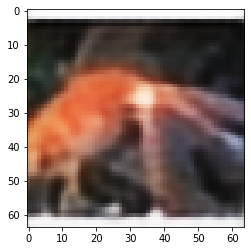

In [14]:
plt.imshow(ref_op.transpose(1,2,0))

In [ ]:
plt.imshow(cladec_op.transpose(1,2,0))

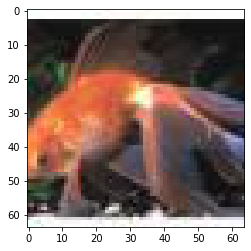

In [16]:
plt.imshow(ex.numpy().transpose(1,2,0))

In [7]:
import numpy as np

In [8]:
ae_metrics = torch.load("/home/harshv834/ClaDec/trained_models/TinyImgNet/ae_metrics.pt")
cladec_metrics = torch.load("/home/harshv834/ClaDec/trained_models/TinyImgNet/cladec_metrics.pt")

In [18]:

cladec_train_loss_list = []
cladec_val_loss_list = []
cladec_val_acc = []


for i in tqdm(range(2,3)):
    cladecNet = torch.load("trained_models/TinyImgNet/check_0.01_cladecNet_2.pt")
    cfg["layInd"] = -1*i
    
    actModel = cladec.getActModel(cfg, classifier)
    refAE.eval()
    cladecNet.eval()
    actModel.eval()
    
    train_acts = getActs(train_loader, actModel, cfg)
    val_acts = getActs(val_loader, actModel, cfg)
    
    cladec_train = getReconstr(train_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=True)
    cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet)
    cladec_val= getReconstr(val_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=False)
    cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet)
    
    cladec_train_loss_list.append(cladec_train_loss)
    cladec_val_loss_list.append(cladec_val_loss)

    
    clf_cladec, lcfg_cladec = clModel.getclassifier(cfg,  cladec_train, cladec_val, norm=None)
    cladec_val_acc.append(lcfg_cladec["testAcc"])
#    torch.save(clf_cladec,"trained_models/TinyImgNet/check_clf_cladec_" + str(i) + ".pt")
#torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, "trained_models/TinyImgNet/check_cladec_metrics.pt")
#torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, "trained_models/TinyImgNet/check_ae_metrics.pt")




782it [00:22, 35.05it/s]:00<?, ?it/s]
782it [00:22, 34.58it/s]

0it [00:00, ?it/s]/60 [00:00<?, ?it/s]

Train Classifier to explain


782it [00:30, 25.68it/s]

0it [00:00, ?it/s]/60 [00:54<53:42, 54.63s/it]

0 [5.05653 0.0263  0.02506]


782it [00:30, 25.41it/s]

782it [00:31, 25.13it/s]1:27<40:15, 41.65s/it]

782it [00:30, 25.44it/s]2:00<35:47, 37.67s/it]

782it [00:30, 25.81it/s]2:32<33:15, 35.63s/it]

0it [00:00, ?it/s]/60 [03:26<38:46, 42.29s/it]

4 [4.2029  0.0892  0.09833]


782it [00:30, 25.49it/s]

782it [00:31, 25.19it/s]3:59<35:03, 38.95s/it]

782it [00:30, 25.77it/s]4:32<32:38, 36.94s/it]

782it [00:30, 25.95it/s]5:04<30:41, 35.41s/it]

0it [00:00, ?it/s]/60 [05:57<34:59, 41.17s/it]

8 [3.90959 0.1126  0.13381]


782it [00:30, 25.69it/s]

782it [00:30, 25.67it/s]06:30<32:00, 38.41s/it]

782it [00:30, 25.62it/s]07:02<29:49, 36.53s/it]

782it [00:30, 25.76it/s]07:34<28:11, 35.24s/it]

0it [00:00, ?it/s]3/60 [08:28<32:05, 40.98s/it]

12 [3.7819  0.1397  0.15472]


782it [00:30, 25.81it/s]

782it [00:30, 25.43it/s]09:01<29:21, 38.29s/it]

782it [00:30, 25.43it/s]09:33<27:25, 36.56s/it]

782it [00:30, 25.30it/s]10:06<25:55, 35.35s/it]

782it [00:30, 25.75it/s]10:38<24:45, 34.56s/it]

782it [00:30, 25.26it/s]11:10<23:40, 33.83s/it]

782it [00:30, 25.69it/s]11:43<22:53, 33.50s/it]

782it [00:30, 25.44it/s]12:15<22:04, 33.12s/it]

0it [00:00, ?it/s]1/60 [13:10<25:38, 39.46s/it]

20 [3.73321 0.1369  0.15781]


782it [00:29, 26.17it/s]

782it [00:30, 25.53it/s]13:41<23:30, 37.12s/it]

782it [00:30, 25.89it/s]14:14<22:01, 35.70s/it]

782it [00:30, 25.79it/s]14:46<20:45, 34.59s/it]

782it [00:30, 25.79it/s]15:18<19:44, 33.85s/it]

782it [00:29, 26.19it/s]15:50<18:53, 33.33s/it]

782it [00:30, 25.84it/s]16:22<18:03, 32.83s/it]

782it [00:30, 25.70it/s]16:54<17:23, 32.60s/it]

782it [00:30, 25.69it/s]17:26<16:46, 32.48s/it]

782it [00:29, 26.14it/s]17:58<16:11, 32.40s/it]

782it [00:30, 26.00it/s]18:30<15:32, 32.17s/it]

782it [00:30, 25.63it/s]19:02<14:58, 32.08s/it]

782it [00:30, 26.00it/s]19:34<14:27, 32.13s/it]

782it [00:30, 25.73it/s]20:06<13:53, 32.04s/it]

782it [00:30, 25.70it/s]20:38<13:22, 32.08s/it]

782it [00:30, 25.39it/s]21:10<12:50, 32.12s/it]

782it [00:30, 25.72it/s]21:43<12:21, 32.25s/it]

782it [00:30, 25.31it/s]22:15<11:48, 32.23s/it]

782it [00:30, 25.47it/s]22:48<11:19, 32.37s/it]

782it [00:30, 25.61it/s]23:20<10:47, 32.39s/it]

0it [00:00, ?it/s]1/60 [24:15<12:22, 39.05s

40 [3.41223 0.1921  0.21159]


782it [00:30, 25.91it/s]

782it [00:30, 25.25it/s]24:47<11:04, 36.93s/it]

782it [00:30, 25.66it/s]25:19<10:06, 35.67s/it]

782it [00:30, 25.77it/s]25:51<09:14, 34.63s/it]

782it [00:30, 25.45it/s]26:24<08:28, 33.88s/it]

782it [00:30, 25.56it/s]26:56<07:48, 33.48s/it]

782it [00:30, 25.46it/s]27:29<07:10, 33.15s/it]

782it [00:30, 25.58it/s]28:01<06:35, 32.95s/it]

782it [00:30, 25.44it/s]28:33<06:00, 32.76s/it]

782it [00:30, 25.65it/s]29:06<05:26, 32.69s/it]

782it [00:30, 25.28it/s]29:38<04:53, 32.56s/it]

782it [00:30, 25.37it/s]30:11<04:20, 32.60s/it]

782it [00:30, 25.68it/s]30:43<03:48, 32.59s/it]

782it [00:30, 25.51it/s]31:16<03:14, 32.50s/it]

782it [00:30, 25.79it/s]31:48<02:42, 32.47s/it]

782it [00:30, 25.90it/s]32:20<02:09, 32.35s/it]

782it [00:30, 25.23it/s]32:52<01:36, 32.23s/it]

782it [00:30, 25.94it/s]33:25<01:04, 32.39s/it]

782it [00:30, 25.85it/s]33:57<00:32, 32.24s/it]

100%|██████████| 1/1 [35:38<00:00, 2138.00s/it]


In [20]:
cladec_val_acc

[0.2017]

In [15]:
#cfg["alpha"] = 1e-1
from cladec import getActModel, getClaDec, getRefAE
model_path = "trained_models/TinyImgNet_{}".format(str(cfg["alpha"]))
os.makedirs(model_path, exist_ok=True)
cfg["opt"] = ('S', 1 if dummy else 60, 0.001, 0.0002)
train_loader, val_loader,_, trainset, valset=dutils.getFullDS(cfg, reconstr=True)
classifier.eval()
ae_train_loss_list = []
ae_val_loss_list = []
cladec_train_loss_list = []
cladec_val_loss_list = []
cladec_val_acc = []
refae_val_acc = []

for i in tqdm(range(1, 6)):
    refae_path = os.path.join(model_path, "refAE_{}.pt".format(str(i)))
    cladec_path = os.path.join(model_path, "cladecNet_{}.pt".format(str(cfg["alpha"]),str(i)))
    cfg["layInd"] = -1*i
    #get Activations
    actModel = getActModel(cfg, classifier)
    actModel.eval()
    trds=getActs(train_loader,actModel,cfg)

    refAE,rcfg = getRefAE(cfg,trds) #Does not use activations themselves, only needs shape
    print(rcfg)
    torch.save(refAE.state_dict(), refae_path)

    # Train ClaDec
    cladecNet,ccfg=  getClaDec(cfg,classifier,None,trds)
    print("ClaDec Final loss", ccfg)
    torch.save(cladecNet, cladec_path)
    
    refAE.eval()
    cladecNet.eval()
    actModel.eval()
    
    train_acts = getActs(train_loader, actModel, cfg)
    val_acts = getActs(val_loader, actModel, cfg)
    
    cladec_train = getReconstr(train_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=True)
    refae_train = getReconstr(train_loader, refAE,cfg, train=True)
    cladec_train_loss, refae_train_loss = getReconstrDS(train_acts, refAE, cladecNet)
    cladec_val= getReconstr(val_loader, torch.nn.Sequential(actModel, cladecNet),cfg, train=False)
    refae_val = getReconstr(val_loader, refAE,cfg, train=False)
    cladec_val_loss, refae_val_loss = getReconstrDS(train_acts, refAE, cladecNet)
    
    ae_train_loss_list.append(refae_train_loss)
    ae_val_loss_list.append(refae_val_loss)
    cladec_train_loss_list.append(cladec_train_loss)
    cladec_val_loss_list.append(cladec_val_loss)

    
    clf_cladec, lcfg_cladec = clModel.getclassifier(cfg,  cladec_train, cladec_val, norm=None)
    cladec_val_acc.append(lcfg_cladec["testAcc"])
    torch.save(clf_cladec,os.path.join(model_path,"clf_cladec_" + str(i) + ".pt"))
    clf_ae, lcfg_ae = clModel.getclassifier(cfg,  refae_train, refae_val, norm=None)
    refae_val_acc.append(lcfg_ae["testAcc"])
    torch.save(clf_ae,os.path.join(model_path,"clf_ae_" + str(i) + ".pt"))
    torch.save({"cladec_train_loss" : cladec_train_loss_list, "cladec_val_loss": cladec_val_loss_list, "cladec_val_acc" : cladec_val_acc}, os.path.join(model_path,"cladec_metrics_{}.pt".format(str(i))))
    torch.save({"ae_train_loss" : ae_train_loss_list, "ae_val_loss": ae_val_loss_list, "ae_val_acc" : refae_val_acc}, os.path.join(model_path,"ae_metrics_{}.pt".format(str(i))))





  0%|          | 0/5 [00:00<?, ?it/s]

Train RefAE



  2%|▏         | 1/60 [00:44<43:48, 44.54s/it]

0 [0.03968]



  5%|▌         | 3/60 [02:13<42:25, 44.65s/it]

2 [0.03113]



  8%|▊         | 5/60 [03:43<40:55, 44.65s/it]

4 [0.03035]



 12%|█▏        | 7/60 [05:12<39:22, 44.58s/it]

6 [0.0291]



 15%|█▌        | 9/60 [06:41<37:50, 44.52s/it]

8 [0.02828]



 18%|█▊        | 11/60 [08:10<36:21, 44.53s/it]

10 [0.02756]



 35%|███▌      | 21/60 [20:05<51:09, 78.70s/it]  

20 [0.02567]



 52%|█████▏    | 31/60 [27:25<21:43, 44.96s/it]

30 [0.0245]



 68%|██████▊   | 41/60 [34:44<13:55, 43.98s/it]

40 [0.02409]



 85%|████████▌ | 51/60 [42:04<06:35, 43.96s/it]

50 [0.02415]



100%|██████████| 60/60 [48:39<00:00, 48.66s/it]


{'RefAELo': 0.023992891701995107}
Train CLaDec



  0%|          | 0/5 [48:41<?, ?it/s]


NameError: name 'getnorm' is not defined

In [35]:
op = netDec(img.cuda())

In [68]:
idx = 300
from tqdm import tqdm
for i,(img, sample) in enumerate(tqdm(train_loader, position=0, le):
    if i == idx:
        break

 38%|███▊      | 300/782 [00:11<00:18, 26.66it/s]


In [114]:
for i, (data) in enumerate(tqdm(trds, position=0, leave=True)):
    print(i)

5it [00:00, 12.06it/s]

0
1
2
3
4
5
6
7


13it [00:00, 19.10it/s]

8
9
10
11
12
13
14


17it [00:01, 19.41it/s]

15
16
17
18
19


24it [00:01, 20.80it/s]

20
21
22
23
24


29it [00:01, 25.22it/s]

25
26
27
28
29
30


35it [00:01, 23.78it/s]

31
32
33
34


38it [00:01, 21.11it/s]

35
36
37
38


44it [00:02, 20.05it/s]

39
40
41
42
43


47it [00:02, 19.36it/s]

44
45
46
47
48


54it [00:02, 23.10it/s]

49
50
51
52
53
54


58it [00:02, 26.07it/s]

55
56
57
58
59


64it [00:03, 21.44it/s]

60
61
62
63


67it [00:03, 21.42it/s]

64
65
66
67
68
69
70


76it [00:03, 27.10it/s]

71
72
73
74
75
76
77


83it [00:03, 28.41it/s]

78
79
80
81
82
83


86it [00:03, 25.30it/s]

84
85
86
87


92it [00:04, 23.46it/s]

88
89
90
91
92


98it [00:04, 21.18it/s]

93
94
95
96
97


101it [00:04, 22.05it/s]

98
99
100
101


104it [00:04, 19.67it/s]

102
103
104
105


109it [00:05, 18.85it/s]

106
107
108
109


113it [00:05, 17.52it/s]

110
111
112


119it [00:05, 21.33it/s]

113
114
115
116
117
118


122it [00:05, 20.27it/s]

119
120
121
122


128it [00:06, 22.33it/s]

123
124
125
126
127


131it [00:06, 23.07it/s]

128
129
130
131
132
133


138it [00:06, 25.28it/s]

134
135
136
137
138


144it [00:06, 23.05it/s]

139
140
141
142
143
144


152it [00:06, 28.19it/s]

145
146
147
148
149
150
151
152


155it [00:07, 25.77it/s]

153
154
155
156


161it [00:07, 21.33it/s]

157
158
159
160


164it [00:07, 21.66it/s]

161
162
163
164
165
166
167


172it [00:07, 24.51it/s]

168
169
170
171
172
173


178it [00:08, 23.06it/s]

174
175
176
177


184it [00:08, 25.53it/s]

178
179
180
181
182
183
184
185


191it [00:08, 25.14it/s]

186
187
188
189
190
191


194it [00:08, 20.38it/s]

192
193
194
195


200it [00:09, 22.05it/s]

196
197
198
199
200
201

203it [00:09, 22.84it/s]


202
203
204


209it [00:09, 22.67it/s]

205
206
207
208
209


215it [00:09, 22.27it/s]

210
211
212
213
214


218it [00:09, 20.55it/s]

215
216
217
218
219


227it [00:10, 28.92it/s]

220
221
222
223
224
225
226
227


233it [00:10, 27.98it/s]

228
229
230
231
232
233

239it [00:10, 26.25it/s]


234
235
236
237
238
239


245it [00:10, 25.43it/s]

240
241
242
243
244
245


248it [00:10, 23.91it/s]

246
247
248
249


254it [00:11, 19.32it/s]

250
251
252
253


262it [00:11, 26.35it/s]

254
255
256
257
258
259
260
261


265it [00:11, 24.10it/s]

262
263
264
265
266


271it [00:12, 22.77it/s]

267
268
269
270


274it [00:12, 23.15it/s]

271
272
273
274
275
276


281it [00:12, 22.85it/s]

277
278
279
280


284it [00:12, 20.53it/s]

281
282
283
284
285


293it [00:12, 29.06it/s]

286
287
288
289
290
291
292
293
294


300it [00:13, 24.39it/s]

295
296
297
298
299


307it [00:13, 27.81it/s]

300
301
302
303
304
305
306


311it [00:13, 26.97it/s]

307
308
309
310
311
312


314it [00:13, 26.87it/s]

313
314


320it [00:14, 19.51it/s]

315
316
317
318
319


323it [00:14, 19.98it/s]

320
321
322
323
324


330it [00:14, 21.98it/s]

325
326
327
328
329


334it [00:14, 22.14it/s]

330
331
332
333
334


338it [00:14, 23.06it/s]

335
336
337
338
339


346it [00:15, 28.27it/s]

340
341
342
343
344
345
346
347


354it [00:15, 27.95it/s]

348
349
350
351
352
353


357it [00:15, 24.62it/s]

354
355
356
357

364it [00:15, 26.27it/s]


358
359
360
361
362
363


367it [00:16, 24.20it/s]

364
365
366
367
368


373it [00:16, 24.22it/s]

369
370
371
372
373
374
375
376
377


383it [00:16, 27.83it/s]

378
379
380
381
382


387it [00:16, 27.00it/s]

383
384
385
386
387
388


391it [00:16, 23.20it/s]

389
390
391


399it [00:17, 27.11it/s]

392
393
394
395
396
397
398
399


402it [00:17, 25.75it/s]

400
401
402
403

408it [00:17, 26.22it/s]


404
405
406
407
408
409


411it [00:17, 26.80it/s]

410
411
412


417it [00:18, 19.11it/s]

413
414
415
416


420it [00:18, 19.15it/s]

417
418
419
420
421


426it [00:18, 22.00it/s]

422
423
424
425
426
427


432it [00:18, 22.05it/s]

428
429
430
431
432


438it [00:19, 23.39it/s]

433
434
435
436
437
438


444it [00:19, 24.70it/s]

439
440
441
442
443


447it [00:19, 21.14it/s]

444
445
446
447


456it [00:19, 28.18it/s]

448
449
450
451
452
453
454
455


460it [00:19, 26.17it/s]

456
457
458
459
460
461

466it [00:20, 26.32it/s]


462
463
464
465


469it [00:20, 20.13it/s]

466
467
468
469


477it [00:20, 23.59it/s]

470
471
472
473
474
475
476


483it [00:20, 23.77it/s]

477
478
479
480
481
482


486it [00:21, 20.78it/s]

483
484
485
486
487


493it [00:21, 24.13it/s]

488
489
490
491
492
493


498it [00:21, 25.04it/s]

494
495
496
497
498
499
500

502it [00:21, 27.68it/s]


501
502
503


508it [00:21, 22.73it/s]

504
505
506
507
508


514it [00:22, 22.62it/s]

509
510
511
512
513


522it [00:22, 27.55it/s]

514
515
516
517
518
519
520
521
522


528it [00:22, 26.27it/s]

523
524
525
526
527
528


534it [00:23, 23.89it/s]

529
530
531
532
533
534


538it [00:23, 24.97it/s]

535
536
537
538
539


544it [00:23, 23.36it/s]

540
541
542
543
544


550it [00:23, 21.45it/s]

545
546
547
548
549
550
551


557it [00:24, 23.46it/s]

552
553
554
555
556


561it [00:24, 27.36it/s]

557
558
559
560
561
562


567it [00:24, 24.23it/s]

563
564
565
566
567
568


574it [00:24, 25.98it/s]

569
570
571
572
573
574
575


581it [00:24, 26.07it/s]

576
577
578
579
580


585it [00:25, 26.36it/s]

581
582
583
584
585
586
587


593it [00:25, 24.68it/s]

588
589
590
591
592


596it [00:25, 21.78it/s]

593
594
595
596
597
598


600it [00:25, 23.79it/s]

599
600
601
602


606it [00:26, 19.76it/s]

603
604
605
606


613it [00:26, 22.78it/s]

607
608
609
610
611
612
613
614
615


619it [00:26, 29.67it/s]

616
617
618
619
620
621


626it [00:26, 22.89it/s]

622
623
624
625


629it [00:27, 21.92it/s]

626
627
628
629
630
631


636it [00:27, 23.14it/s]

632
633
634
635
636
637

643it [00:27, 25.46it/s]


638
639
640
641
642


650it [00:27, 28.58it/s]

643
644
645
646
647
648
649
650


656it [00:28, 25.24it/s]

651
652
653
654
655
656


660it [00:28, 23.99it/s]

657
658
659
660
661
662


668it [00:28, 25.19it/s]

663
664
665
666
667


678it [00:28, 33.70it/s]

668
669
670
671
672
673
674
675
676
677


682it [00:28, 32.60it/s]

678
679
680
681
682
683
684


690it [00:29, 25.59it/s]

685
686
687
688
689


693it [00:29, 21.02it/s]

690
691
692


696it [00:29, 19.26it/s]

693
694
695
696


705it [00:30, 25.66it/s]

697
698
699
700
701
702
703
704


708it [00:30, 26.13it/s]

705
706
707
708
709


715it [00:30, 25.16it/s]

710
711
712
713
714
715
716


719it [00:30, 22.69it/s]

717
718
719
720


727it [00:30, 26.41it/s]

721
722
723
724
725
726


730it [00:31, 24.98it/s]

727
728
729
730


733it [00:31, 22.19it/s]

731
732
733
734
735


739it [00:31, 20.07it/s]

736
737
738
739
740


745it [00:31, 22.16it/s]

741
742
743
744
745
746
747
748


754it [00:32, 29.99it/s]

749
750
751
752
753
754
755


758it [00:32, 30.71it/s]

756
757
758
759


765it [00:32, 23.85it/s]

760
761
762
763
764
765


768it [00:32, 25.01it/s]

766
767
768
769


774it [00:32, 21.85it/s]

770
771
772
773


782it [00:33, 23.61it/s]

774
775
776
777
778
779
780
781


In [103]:
i=0
for _ in trds:
    print(i)

0
